In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re  # for pattern matching and text manipulation
import string
import nltk
from sklearn.preprocessing import LabelEncoder
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer as CV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

In [5]:
train_data = pd.read_csv("/content/train_data.txt", sep=':::', names=["title", "genre", "description"], engine='python')
test_data = pd.read_csv("/content/test_data.txt", sep=':::', names=["title", "description"], engine='python')

In [6]:
# Data overview
print(train_data.head())
print(test_data.head())

                                title       genre  \
1       Oscar et la dame rose (2009)       drama    
2                       Cupid (1997)    thriller    
3   Young, Wild and Wonderful (1980)       adult    
4              The Secret Sin (1915)       drama    
5             The Unrecovered (2007)       drama    

                                         description  
1   Listening in to a conversation between his do...  
2   A brother and sister with a past incestuous r...  
3   As the bus empties the students for their fie...  
4   To help their unemployed father make ends mee...  
5   The film's title refers not only to the un-re...  
                           title  \
1          Edgar's Lunch (1998)    
2      La guerra de papá (1977)    
3   Off the Beaten Track (2010)    
4        Meu Amigo Hindu (2015)    
5             Er nu zhai (1955)    

                                         description  
1   L.R. Brane loves his life - his car, his apar...  
2   Spain, March 1964: Q

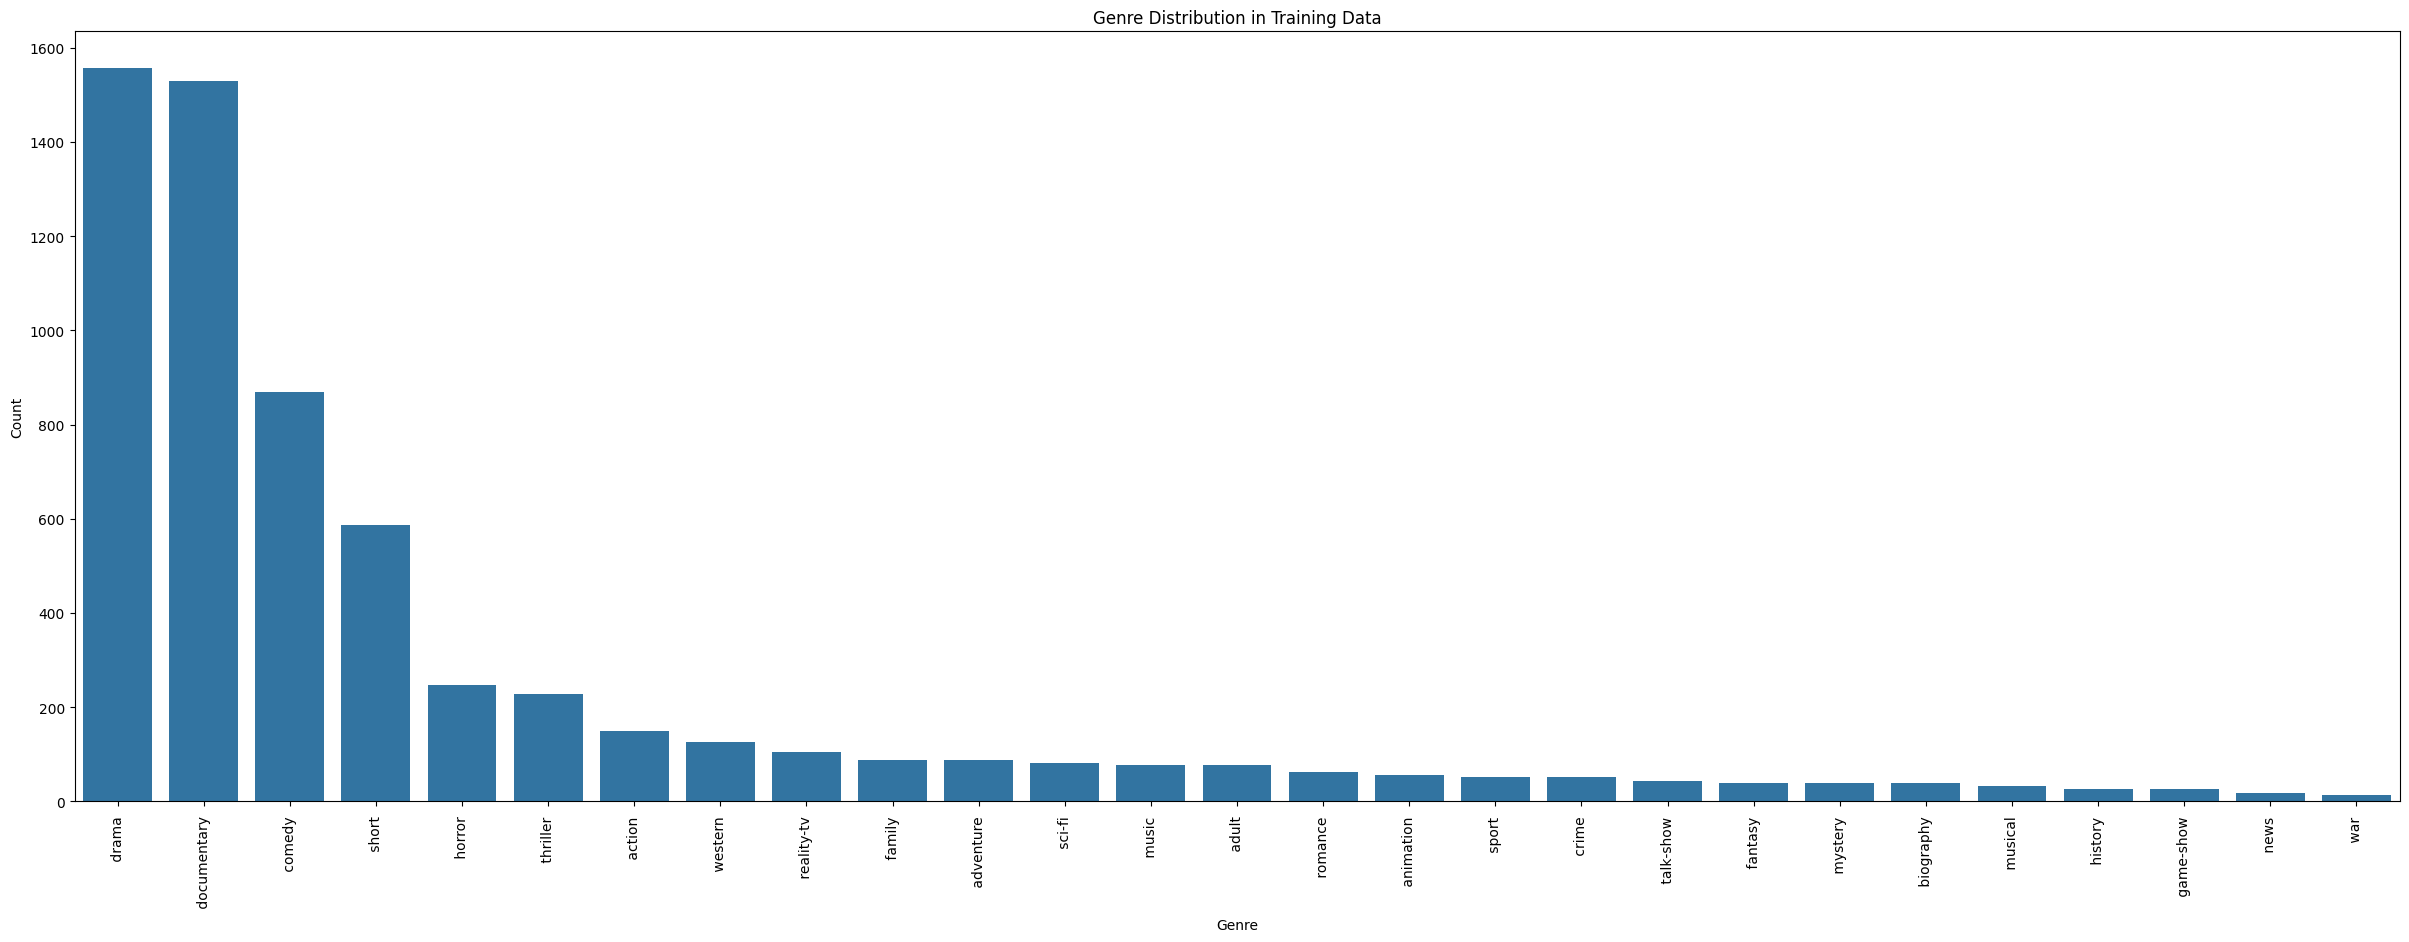

In [7]:
# Visualize genre distribution
plt.figure(figsize=(30,10))
genre_counts = train_data.genre.value_counts()
sns.barplot(x=genre_counts.index, y=genre_counts)
plt.xlabel('Genre')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.title('Genre Distribution in Training Data')
plt.show()

In [8]:
# Data summary
print(train_data.describe())
print(train_data.genre.value_counts())
print(train_data.info())
print(train_data.isnull().sum())


                                 title    genre  \
count                             6311     6311   
unique                            6311       27   
top      Oscar et la dame rose (2009)    drama    
freq                                 1     1557   

                                              description  
count                                                6311  
unique                                               6309  
top      Olga, Masha, and Irina Prozoroff lead lonely ...  
freq                                                    2  
genre
 drama           1557
 documentary     1530
 comedy           869
 short            587
 horror           248
 thriller         227
 action           149
 western          125
 reality-tv       105
 family            88
 adventure         87
 sci-fi            82
 music             77
 adult             77
 romance           63
 animation         57
 sport             52
 crime             51
 talk-show         44
 fantasy           4

In [9]:
# Drop duplicates
print("Shape before dropping duplicates:", train_data.shape)
train_data = train_data.drop_duplicates()
print("Shape after dropping duplicates:", train_data.shape)

Shape before dropping duplicates: (6311, 3)
Shape after dropping duplicates: (6311, 3)


In [10]:
# Download NLTK data
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [11]:
# Text cleaning function
stop_words = set(stopwords.words('english'))

In [12]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r'@\S+|http\S+|[\w\.-]+@[\w\.-]+|[^a-zA-Z\']|pic.\S+|#|_|\n|\[[^]]*\]', ' ', text)
    text = re.sub(r'\s+[a-zA-Z]\s+', ' ', text + ' ')
    text = "".join([char for char in text if char not in string.punctuation])
    text = re.sub("\s+", " ", text).strip()
    tokens = word_tokenize(text)
    text = " ".join([word for word in tokens if word not in stop_words and len(word) > 2])
    return text

In [13]:
# Clean text data
train_data['description_cleaned'] = train_data['description'].apply(clean_text)
test_data['description_cleaned'] = test_data['description'].apply(clean_text)


In [14]:
# Apply stemming
stemmer = PorterStemmer()
train_data['description_cleaned'] = train_data['description_cleaned'].apply(lambda x: ' '.join([stemmer.stem(word) for word in x.split()]))
test_data['description_cleaned'] = test_data['description_cleaned'].apply(lambda x: ' '.join([stemmer.stem(word) for word in x.split()]))



In [15]:

# Text length analysis
train_data['length'] = train_data['description'].apply(len)
train_data['length_cleaned'] = train_data['description_cleaned'].apply(len)
print(train_data.head())


                                title       genre  \
1       Oscar et la dame rose (2009)       drama    
2                       Cupid (1997)    thriller    
3   Young, Wild and Wonderful (1980)       adult    
4              The Secret Sin (1915)       drama    
5             The Unrecovered (2007)       drama    

                                         description  \
1   Listening in to a conversation between his do...   
2   A brother and sister with a past incestuous r...   
3   As the bus empties the students for their fie...   
4   To help their unemployed father make ends mee...   
5   The film's title refers not only to the un-re...   

                                 description_cleaned  length  length_cleaned  
1  listen convers doctor parent year old oscar le...     546             339  
2  brother sister past incestu relationship curre...     184             111  
3  bu empti student field trip museum natur histo...     650             344  
4  help unemploy father make

In [16]:
# Average text length
print("Average Length of Text Before Cleaning:", train_data['length'].mean())
print("Average Length of Text After Cleaning:", train_data['length_cleaned'].mean())

Average Length of Text Before Cleaning: 612.2774520678181
Average Length of Text After Cleaning: 366.8599271113928


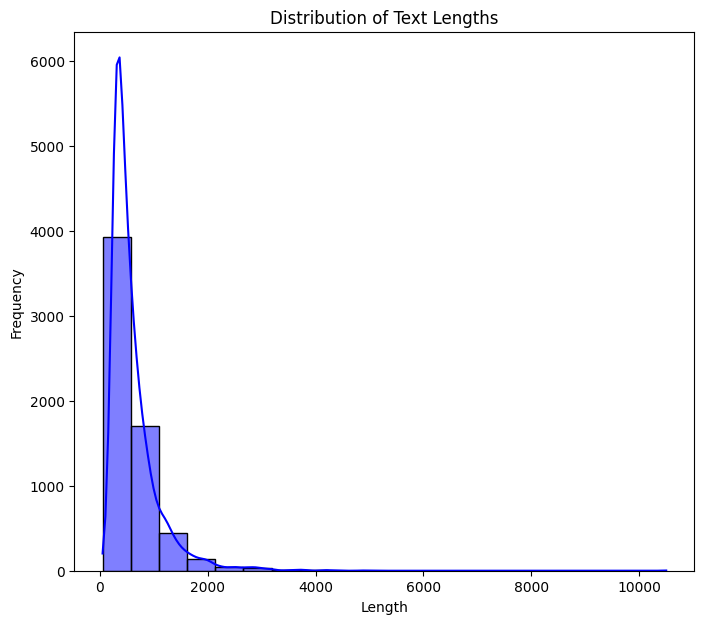

In [17]:
# Plot text length distribution
plt.figure(figsize=(8, 7))
sns.histplot(data=train_data, x='length', bins=20, kde=True, color='blue')
plt.xlabel('Length')
plt.ylabel('Frequency')
plt.title('Distribution of Text Lengths')
plt.show()

In [18]:
# Top 10 bigrams visualization
def get_top_n_bigrams(corpus, n=None):
    vec = CV(ngram_range=(2, 2)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    return words_freq[:n]

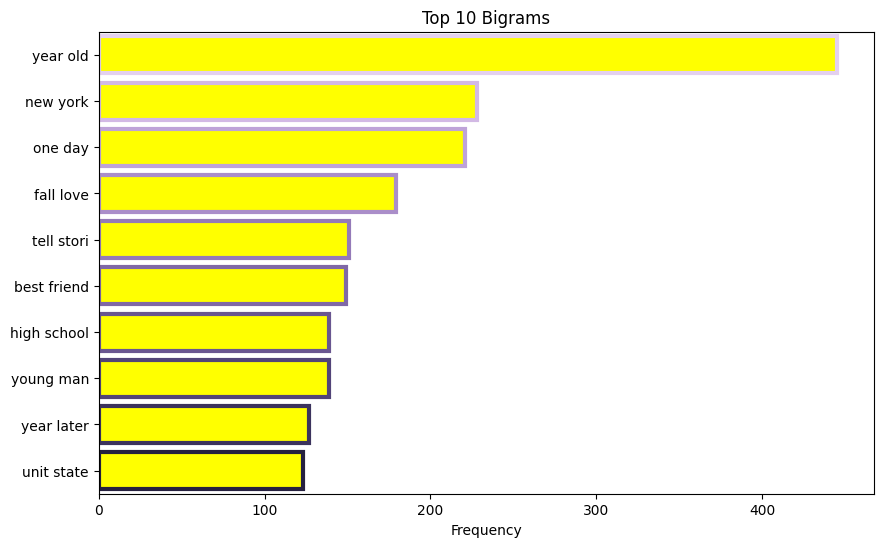

In [19]:

common_bigrams = get_top_n_bigrams(train_data['description_cleaned'], 10)
common_bigrams_df = pd.DataFrame(common_bigrams, columns=['bigram', 'freq'])
plt.figure(figsize=(10, 6))
sns.barplot(x='freq', y='bigram', data=common_bigrams_df, facecolor='yellow', linewidth=3, edgecolor=sns.color_palette("ch:start=3, rot=.1", 10))
plt.title("Top 10 Bigrams")
plt.xlabel("Frequency")
plt.ylabel("")
plt.show()

In [20]:
# Encode genre labels
label_encoder = LabelEncoder()
train_data['genre'] = label_encoder.fit_transform(train_data['genre'].values)

In [21]:
# Keep relevant columns
train_df = train_data[['description_cleaned', 'genre']]
test_df = test_data[['description_cleaned', 'title']]
print(train_df.head(10))

                                  description_cleaned  genre
1   listen convers doctor parent year old oscar le...      8
2   brother sister past incestu relationship curre...     24
3   bu empti student field trip museum natur histo...      1
4   help unemploy father make end meet edith twin ...      8
5   film titl refer recov bodi ground zero also st...      8
6   qualiti control consist seri singl take shot f...      7
7   tough econom time max joey run idea discov sen...      5
8   ron petri keanu reev troubl teen whose life ha...      6
9   sudden calamit event caus great loss life dama...     18
10  four high school student embark terrifi journe...     13


In [22]:
# Split data into training and validation sets
train_set, val_set, train_labels, val_labels = train_test_split(train_df['description_cleaned'], train_df['genre'], test_size=0.2, shuffle=True, random_state=42)
print(f'Split data into train and validation sets')
print(f'Train Set: {len(train_set)}\nValidation Set: {len(val_set)}')

Split data into train and validation sets
Train Set: 5048
Validation Set: 1263


In [23]:
# Vectorize text data using TF-IDF
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_features=100000)
train_set_tfidf = tfidf_vectorizer.fit_transform(train_set)
val_set_tfidf = tfidf_vectorizer.transform(val_set)

In [24]:

# Train Logistic Regression model
log_reg_model = LogisticRegression()
log_reg_model.fit(train_set_tfidf, train_labels)
log_reg_preds = log_reg_model.predict(val_set_tfidf)
print("Logistic Regression Classification Report:\n", classification_report(val_labels, log_reg_preds))
log_reg_accuracy = accuracy_score(val_labels, log_reg_preds)
print('Logistic Regression Accuracy: {:.2f}%'.format(log_reg_accuracy * 100))

Logistic Regression Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        28
           1       0.00      0.00      0.00        17
           2       0.00      0.00      0.00        15
           3       0.00      0.00      0.00         9
           4       0.00      0.00      0.00         5
           5       0.55      0.39      0.46       186
           6       0.00      0.00      0.00        11
           7       0.57      0.90      0.70       309
           8       0.45      0.87      0.59       316
           9       0.00      0.00      0.00        18
          10       0.00      0.00      0.00         6
          11       0.00      0.00      0.00         6
          12       0.00      0.00      0.00         7
          13       0.71      0.10      0.18        48
          14       0.00      0.00      0.00        17
          15       0.00      0.00      0.00         5
          16       0.00      0.00    

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels wit

In [25]:

# Train Naive Bayes classifier
nb_model = MultinomialNB()
nb_model.fit(train_set_tfidf, train_labels)
nb_preds = nb_model.predict(val_set_tfidf)
print("Naive Bayes Classification Report:\n", classification_report(val_labels, nb_preds))
nb_accuracy = accuracy_score(val_labels, nb_preds)
print('Naive Bayes Accuracy: {:.2f}%'.format(nb_accuracy * 100))

Naive Bayes Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        28
           1       0.00      0.00      0.00        17
           2       0.00      0.00      0.00        15
           3       0.00      0.00      0.00         9
           4       0.00      0.00      0.00         5
           5       0.50      0.01      0.01       186
           6       0.00      0.00      0.00        11
           7       0.53      0.90      0.67       309
           8       0.38      0.89      0.53       316
           9       0.00      0.00      0.00        18
          10       0.00      0.00      0.00         6
          11       0.00      0.00      0.00         6
          12       0.00      0.00      0.00         7
          13       0.00      0.00      0.00        48
          14       0.00      0.00      0.00        17
          15       0.00      0.00      0.00         5
          16       0.00      0.00      0.00  

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [26]:
# Train Decision Tree classifier
dt_model = DecisionTreeClassifier(max_depth=1, random_state=0)
dt_model.fit(train_set_tfidf, train_labels)
dt_preds = dt_model.predict(val_set_tfidf)
print("Decision Tree Classification Report:\n", classification_report(val_labels, dt_preds))
dt_accuracy = accuracy_score(val_labels, dt_preds)
print('Decision Tree Accuracy: {:.2f}%'.format(dt_accuracy * 100))

Decision Tree Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        28
           1       0.00      0.00      0.00        17
           2       0.00      0.00      0.00        15
           3       0.00      0.00      0.00         9
           4       0.00      0.00      0.00         5
           5       0.00      0.00      0.00       186
           6       0.00      0.00      0.00        11
           7       0.88      0.32      0.47       309
           8       0.27      0.99      0.43       316
           9       0.00      0.00      0.00        18
          10       0.00      0.00      0.00         6
          11       0.00      0.00      0.00         6
          12       0.00      0.00      0.00         7
          13       0.00      0.00      0.00        48
          14       0.00      0.00      0.00        17
          15       0.00      0.00      0.00         5
          16       0.00      0.00      0.00

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [27]:
# Train SVM classifier
svm_model = SVC(kernel='linear')
svm_model.fit(train_set_tfidf, train_labels)
svm_preds = svm_model.predict(val_set_tfidf)
print("SVM Classification Report:\n", classification_report(val_labels, svm_preds))
svm_accuracy = accuracy_score(val_labels, svm_preds)
print('SVM Accuracy: {:.2f}%'.format(svm_accuracy * 100))

SVM Classification Report:
               precision    recall  f1-score   support

           0       0.50      0.04      0.07        28
           1       0.00      0.00      0.00        17
           2       0.40      0.13      0.20        15
           3       0.00      0.00      0.00         9
           4       0.00      0.00      0.00         5
           5       0.57      0.47      0.51       186
           6       0.00      0.00      0.00        11
           7       0.61      0.84      0.70       309
           8       0.46      0.84      0.60       316
           9       1.00      0.06      0.11        18
          10       0.00      0.00      0.00         6
          11       1.00      0.50      0.67         6
          12       0.00      0.00      0.00         7
          13       0.58      0.38      0.46        48
          14       0.33      0.06      0.10        17
          15       0.00      0.00      0.00         5
          16       0.00      0.00      0.00         6

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [28]:

# Compile results into DataFrame
results_df = pd.DataFrame({
    'Algorithm': ['Logistic Regression', 'Naive Bayes', 'Decision Tree', 'SVM'],
    'Accuracy': [log_reg_accuracy, nb_accuracy, dt_accuracy, svm_accuracy]
})

<ipython-input-29-b10c3d93311d>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Algorithm', y='Accuracy', data=results_df, palette='viridis')


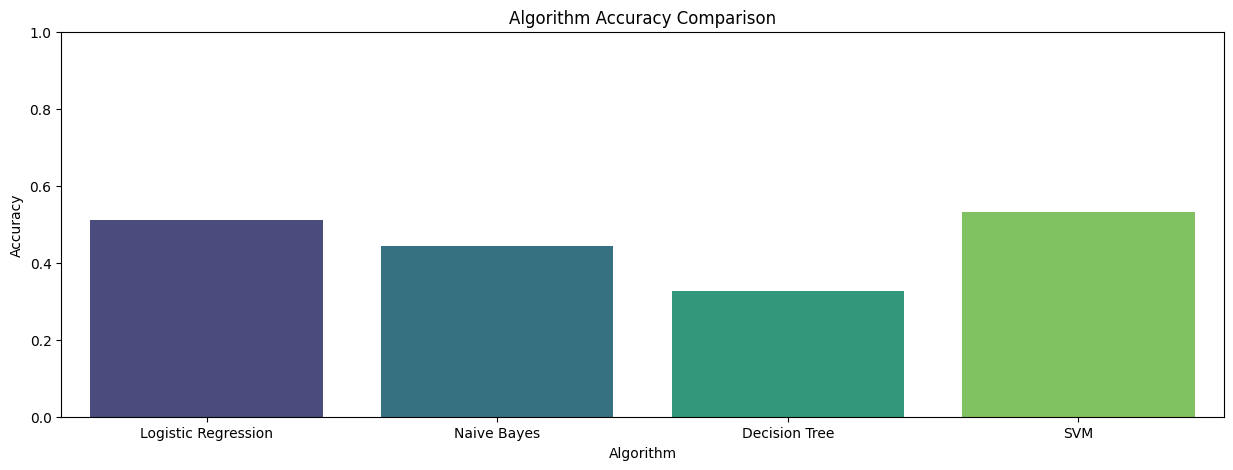

In [29]:
# Visualize results
plt.figure(figsize=(15, 5))
sns.barplot(x='Algorithm', y='Accuracy', data=results_df, palette='viridis')
plt.title('Algorithm Accuracy Comparison')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.show()